# Explore renthop data


The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site. 



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap

In [2]:
train = pd.read_json('data/train.json')
train = train.set_index('listing_id')
train['created'] = pd.to_datetime(train['created'])
train.shape

(49352, 14)

In [3]:
test = pd.read_json('data/test.json')
test = test.set_index('listing_id')
test['created'] = pd.to_datetime(test['created'])
test.shape

(74659, 13)

In [4]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'longitude', 'manager_id', 'photos', 'price', 'street_address'],
      dtype='object')

In [5]:
test.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'longitude', 'manager_id',
       'photos', 'price', 'street_address'],
      dtype='object')

In [6]:
# what is submitted?

submission = pd.read_csv('data/sample_submission.csv.zip', compression='zip')

In [7]:
# for each listing_id will be generating probabilities for each of high, medium , low
submission.head(3)

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683


In [8]:
# sample submission is just the proportions of interest as in the training set
train_proportions = train.interest_level.value_counts(normalize=True)
train_proportions

low       0.694683
medium    0.227529
high      0.077788
Name: interest_level, dtype: float64

# evaluation

multi-class logarithmic loss. 



In [16]:
from sklearn import metrics

In [17]:
predictions = pd.DataFrame({'listing_id': train.index.values, 
              'high': train_proportions['high'],
              'medium': train_proportions['medium'],
              'low': train_proportions['low']})
predictions.head(1)

,high,listing_id,low,medium
0,0.077788,7211212,0.694683,0.227529


In [18]:
predictions = (predictions
                .set_index('listing_id') 
                .assign(actual = train.interest_level)
              )

In [19]:
metrics.log_loss(predictions.actual, predictions.drop('actual', 1).values)

0.78857691143225461

# data exploration

## some distributions

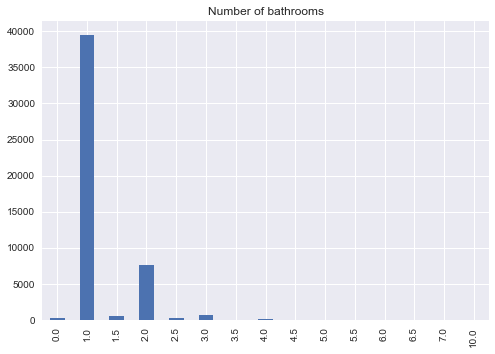

In [20]:
train.bathrooms.value_counts().sort_index().plot.bar()
plt.title('Number of bathrooms')

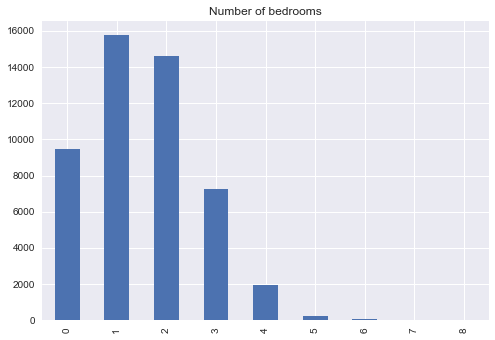

In [21]:
train.bedrooms.value_counts().sort_index().plot.bar()
plt.title('Number of bedrooms')

In [22]:
## is this missing data or....

train.loc[train.bedrooms == 0].shape

(9475, 14)

In [23]:
train.loc[train.bedrooms == 0].interest_level.value_counts()

low       6518
medium    2110
high       847
Name: interest_level, dtype: int64

In [24]:
train.manager_id.nunique()

3481

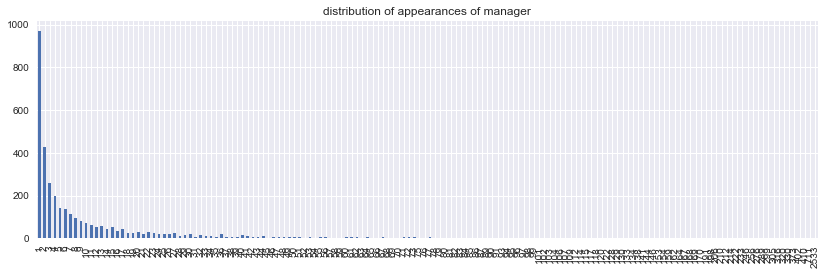

In [26]:
train.manager_id.value_counts().value_counts().sort_index().plot.bar(figsize=(14,4))
plt.title('distribution of appearances of manager')

In [27]:
## maybe there are some managers that are better at getting higher interest level

listings_per_manager_by_interest_level = (train
.groupby(['manager_id', 'interest_level'])
.size()
.reset_index()
.pipe(pd.pivot_table, index='manager_id', columns='interest_level', values=0)
.fillna(0)
.astype(int)[['low', 'medium', 'high']]
)

In [28]:
## how to visualise this?? clustering??

listings_per_manager_by_interest_level.shape

(3481, 3)

In [29]:
interest_proportions_per_manager = listings_per_manager_by_interest_level.divide(listings_per_manager_by_interest_level.sum(1), axis=0)

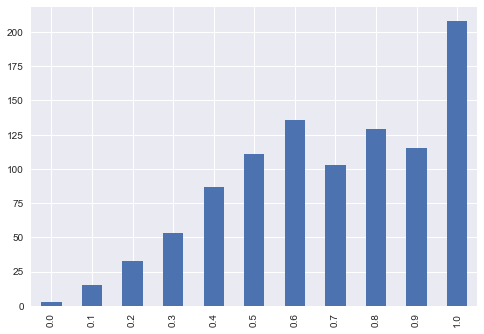

In [30]:
## there seems to be a bunch that only have low interest listings

interest_proportions_per_manager.loc[listings_per_manager_by_interest_level.sum(1) > 10].low.round(1).value_counts().sort_index().plot.bar()

In [31]:
## create feature of being low interest manager_id

In [32]:
low_interest_manager_ids = interest_proportions_per_manager.loc[((listings_per_manager_by_interest_level.sum(1) > 10)
                                     & (interest_proportions_per_manager.low > 0.95))].index.values
low_interest_manager_ids.shape

(207,)

In [33]:
train[train.manager_id.isin(low_interest_manager_ids)].interest_level.value_counts(normalize=True)

low       0.989061
medium    0.008812
high      0.002127
Name: interest_level, dtype: float64

In [34]:
## function to create feature that indicates low interest manager id

train.loc[:,'low_interest_manager_id'] = 0
train.loc[train.manager_id.isin(low_interest_manager_ids), 'low_interest_manager_id'] = 1
train.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address,low_interest_manager_id
listing_id,,,,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,0


In [35]:
test.loc[:,'low_interest_manager_id'] = 0
test.loc[test.manager_id.isin(low_interest_manager_ids), 'low_interest_manager_id'] = 1
test.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,longitude,manager_id,photos,price,street_address,low_interest_manager_id
listing_id,,,,,,,,,,,,,,
7142618,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street,0


In [36]:
train.low_interest_manager_id.sum()

6582

In [37]:
test.low_interest_manager_id.sum()

9644

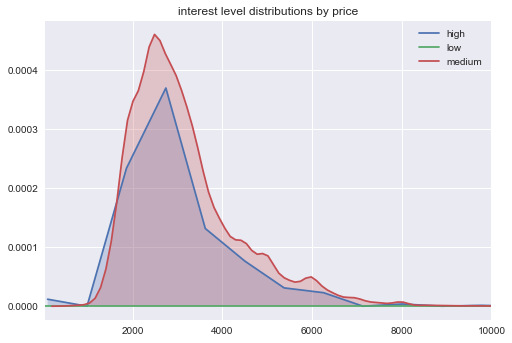

In [38]:

train.groupby('interest_level').apply(lambda x: sns.kdeplot(x.price.astype(int), label=x.name, shade=True))
plt.xlim(50, 10000)
plt.legend()
plt.title('interest level distributions by price')

In [39]:
n_interest_levels = train.interest_level.value_counts()

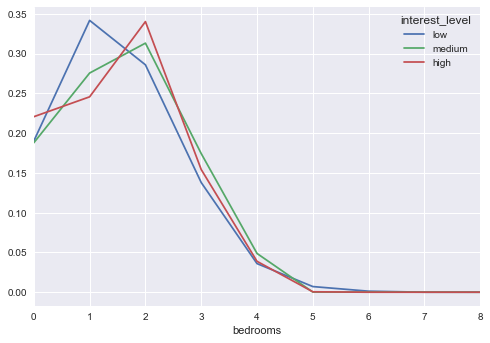

In [40]:
(train
.groupby(['interest_level', 'bedrooms'])
.size()
.reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='bedrooms', values=0)
.fillna(0).astype(int)
[['low', 'medium', 'high']]
.divide(n_interest_levels)
).plot.line()

In [41]:
train['description_length'] = train.description.apply(lambda x: len(x))

In [42]:
test['description_length'] = test.description.apply(lambda x: len(x))

interest_level
high      Axes(0.125,0.125;0.775x0.755)
low       Axes(0.125,0.125;0.775x0.755)
medium    Axes(0.125,0.125;0.775x0.755)
dtype: object

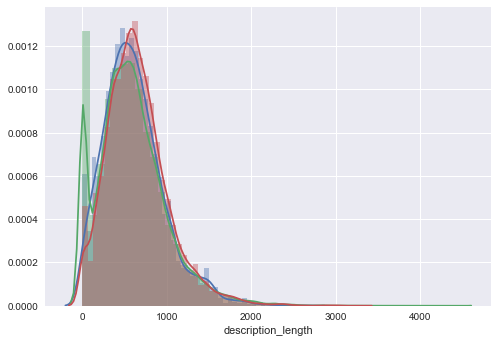

In [43]:
(train
.groupby(['interest_level'])
.apply(lambda x: sns.distplot(x.description_length, label=x.name))
)

In [44]:
train['description_n_words'] = train.description.apply(lambda x: len([x for x in x.split(' ') if x != '']))

In [45]:
test['description_n_words'] = test.description.apply(lambda x: len([x for x in x.split(' ') if x != '']))

## Location

In [46]:
high_latitudes = train.loc[((train.latitude != 0) & (train.longitude != 0) & (train.interest_level == 'high'))]
high_level_latitude = high_latitudes.latitude.tolist()
high_level_longitude = high_latitudes.longitude.tolist()


In [47]:
med_latitudes = train.loc[((train.latitude != 0) & (train.longitude != 0) & (train.interest_level == 'medium'))]
med_level_latitude = med_latitudes.latitude.tolist()
med_level_longitude = med_latitudes.longitude.tolist()


In [48]:
low_latitudes = train.loc[((train.latitude != 0) & (train.longitude != 0) & (train.interest_level == 'low'))]
low_level_latitude = low_latitudes.latitude.tolist()
low_level_longitude = low_latitudes.longitude.tolist()


/Users/danielg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/danielg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/danielg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/danielg/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


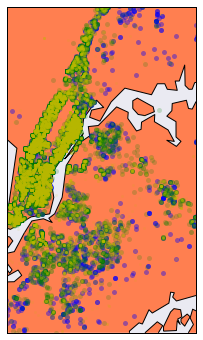

In [49]:
lower = 0.5
upper = 99.5

plt.figure(figsize=(12,6))

my_map = Basemap(projection='merc', 
                 lat_0=np.mean(train.latitude), 
                 lon_0=np.mean(train.longitude),
                 resolution = 'h', 
                 area_thresh = 0.1,
                 llcrnrlon=np.percentile(train.longitude, lower), 
                 llcrnrlat=np.percentile(train.latitude, lower),
                 urcrnrlon=np.percentile(train.longitude, upper), 
                 urcrnrlat=np.percentile(train.latitude, upper))
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='coral')
my_map.drawmapboundary()
 
x,y = my_map(high_level_longitude, high_level_latitude)
my_map.plot(x, y, 'bo', markersize=5, alpha=0.4)

x,y = my_map(med_level_longitude, med_level_latitude)
my_map.plot(x, y, 'go', markersize=5, alpha=0.2)

x,y = my_map(low_level_longitude, low_level_latitude)
my_map.plot(x, y, 'yo', markersize=3, alpha=0.1)

plt.show()

## Created

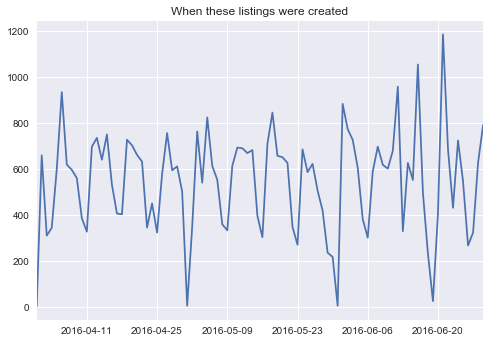

In [50]:
train.created.dt.date.value_counts().sort_index().plot.line()
plt.title('When these listings were created')
plt.show()

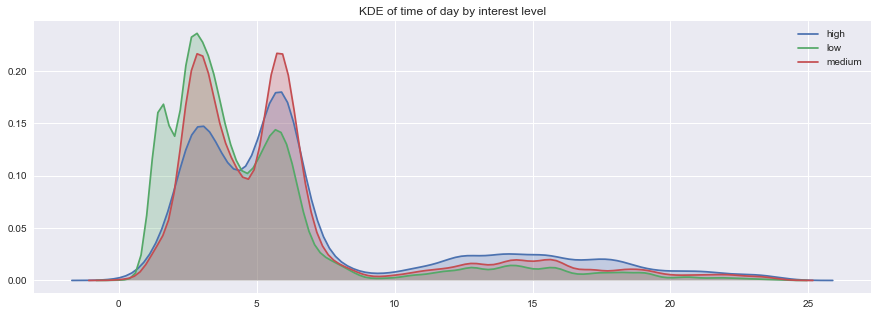

In [51]:
plt.figure(figsize=(15,5))
(train
.groupby('interest_level')
.apply(lambda df: sns.kdeplot((df.created.dt.hour 
                               + (df.created.dt.minute / 60)
                               + (df.created.dt.second / 360))
                              , shade=True, label=df.name))
)
plt.title('KDE of time of day by interest level')
plt.legend()
plt.show()

In [52]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'longitude', 'manager_id', 'photos', 'price', 'street_address',
       'low_interest_manager_id', 'description_length', 'description_n_words'],
      dtype='object')

In [53]:
test.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'longitude', 'manager_id',
       'photos', 'price', 'street_address', 'low_interest_manager_id',
       'description_length', 'description_n_words'],
      dtype='object')

In [54]:
train['day_of_week'] = train['created'].dt.dayofweek
train['hour_of_day'] = train['created'].dt.hour

test['day_of_week'] = test['created'].dt.dayofweek
test['hour_of_day'] = test['created'].dt.hour

In [55]:
train['month'] = train['created'].dt.month

test['month'] = test['created'].dt.month

In [56]:
train['created'].dt.year.value_counts()

2016    49352
Name: created, dtype: int64

In [57]:
train['created'].dt.month.value_counts()

6    17144
4    16411
5    15797
Name: created, dtype: int64

interest_level
high      Axes(0.125,0.125;0.775x0.755)
low       Axes(0.125,0.125;0.775x0.755)
medium    Axes(0.125,0.125;0.775x0.755)
dtype: object

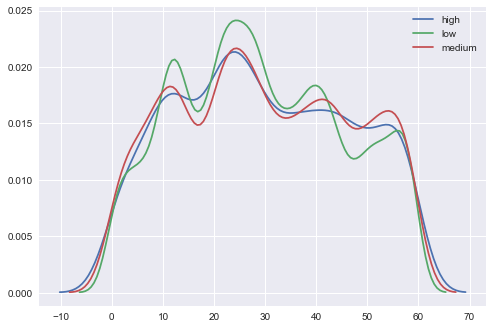

In [166]:
train.groupby('interest_level').apply(lambda x: sns.kdeplot(x.created.dt.minute, label=x.name))

interest_level
high      Axes(0.125,0.125;0.775x0.755)
low       Axes(0.125,0.125;0.775x0.755)
medium    Axes(0.125,0.125;0.775x0.755)
dtype: object

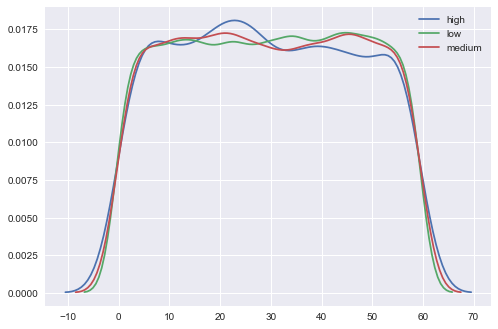

In [167]:
train.groupby('interest_level').apply(lambda x: sns.kdeplot(x.created.dt.second, label=x.name))

## Building Id

In [58]:
train.shape

(49352, 20)

In [59]:
train.building_id.nunique()

7585

In [60]:
## this seems to be higher than the typical distribution?
train[train.building_id=='0'].interest_level.value_counts(normalize=True)

low       0.915762
medium    0.060705
high      0.023534
Name: interest_level, dtype: float64

In [61]:
by_building_id = (train
.loc[train.building_id != '0']
.groupby(['building_id', 'interest_level'])
.size()
.reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='building_id', values=0)
.fillna(0).astype(int)
[['low', 'medium', 'high']]
)

In [62]:
by_building_proportions = by_building_id.divide(by_building_id.sum(1), axis=0)

In [63]:
low_interest_buildings = (by_building_proportions.
                            loc[((by_building_id.sum(1) > 10) & 
                                 (by_building_proportions.low > 0.95))])
low_interest_buildings.head(1)

interest_level,low,medium,high
building_id,,,
009f494b0636f32b96b41926ec7c4bf2,1.0,0.0,0.0


In [64]:
train.loc[train.building_id.isin(low_interest_buildings.index.values)].interest_level.value_counts()

low       1372
medium      23
high         1
Name: interest_level, dtype: int64

In [65]:
train.loc[:,'low_interest_building_id'] = 0
train.loc[train.building_id.isin(low_interest_buildings.index.values), 'low_interest_building_id'] = 1
train.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,...,photos,price,street_address,low_interest_manager_id,description_length,description_n_words,day_of_week,hour_of_day,month,low_interest_building_id
listing_id,,,,,,,,,,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,...,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,0,588,93,4,7,6,0


In [66]:
test.loc[:,'low_interest_building_id'] = 0
test.loc[test.building_id.isin(low_interest_buildings.index.values), 'low_interest_building_id'] = 1
test.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,longitude,manager_id,photos,price,street_address,low_interest_manager_id,description_length,description_n_words,day_of_week,hour_of_day,month,low_interest_building_id
listing_id,,,,,,,,,,,,,,,,,,,,
7142618,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street,0,587,76,5,5,6,0


In [67]:
train.loc[:,'no_building_id'] = 0
train.loc[train.building_id == '0', 'no_building_id'] = 1
train.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,...,price,street_address,low_interest_manager_id,description_length,description_n_words,day_of_week,hour_of_day,month,low_interest_building_id,no_building_id
listing_id,,,,,,,,,,,,,,,,,,,,,
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,-73.9425,...,3000,792 Metropolitan Avenue,0,588,93,4,7,6,0,0


In [68]:
test.loc[:,'no_building_id'] = 0
test.loc[test.building_id == '0', 'no_building_id'] = 1
test.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,longitude,manager_id,...,price,street_address,low_interest_manager_id,description_length,description_n_words,day_of_week,hour_of_day,month,low_interest_building_id,no_building_id
listing_id,,,,,,,,,,,,,,,,,,,,,
7142618,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,-73.9865,b1b1852c416d78d7765d746cb1b8921f,...,2950,99 Suffolk Street,0,587,76,5,5,6,0,0


In [69]:
train.low_interest_building_id.sum()

1396

In [70]:
train.groupby(['low_interest_manager_id', 'low_interest_building_id', 'no_building_id']).size()

low_interest_manager_id  low_interest_building_id  no_building_id
0                        0                         0                 36646
                                                   1                  5002
                         1                         0                  1122
1                        0                         0                  3024
                                                   1                  3284
                         1                         0                   274
dtype: int64

## features

In [71]:
train['n_features'] = train.features.apply(lambda x: len(x))
test['n_features'] = test.features.apply(lambda x: len(x))

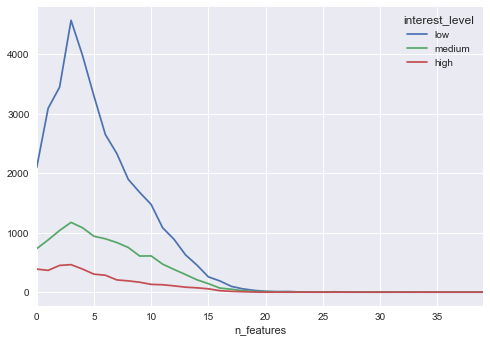

In [72]:
(train
.groupby(['n_features', 'interest_level'])
.size().reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='n_features', values=0)
.fillna(0).astype(int)
 [['low', 'medium', 'high']]
.plot.line()
)

## are there high interest features
+ how many types of features are there?

In [73]:
features = []
for i in train['features']:
    features.extend(i)
features = set(features)

In [74]:
# total number of features
len(features)

1556

In [75]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'longitude', 'manager_id', 'photos', 'price', 'street_address',
       'low_interest_manager_id', 'description_length', 'description_n_words',
       'day_of_week', 'hour_of_day', 'month', 'low_interest_building_id',
       'no_building_id', 'n_features'],
      dtype='object')

In [213]:
import spacy
en_nlp = spacy.load('en')

In [250]:
##
##  want to process the features with spaCy

# def process_word_list(word_list):
#     sentence_clean = word_list.text.replace('\n', ' ').replace('_', '').replace('»', '').replace('«', '')
#     parsed_sentence = parser(sentence_clean)
#     ## drop punctuation...
#     sent_lower = [token.lower_ for token in parsed_sentence]
#     sent_lower = [x for x in sent_lower if x not in punct]


feature_counts = list()
for name, i in train.loc[train.n_features > 0].iterrows():
    id_d = {'listing_id': name, 'interest_level': i.interest_level}
    feature_list = [x.lower() for x in i.features]
    get_punct_out = lambda x: (x
                              .replace(',', '')
                              .replace('  ',' ')
                              .replace('\n', '')
                              .replace('_', '')
                              .replace('.', '')
                              .replace('!', '')
                              .replace('*', '')
                              )
    vals_d = pd.Series(feature_list).value_counts().to_dict()
    row_dict = {**id_d, **vals_d}
    feature_counts.append(row_dict)



feature_counts = pd.DataFrame(feature_counts)

In [251]:
feature_freq = feature_counts.drop(['interest_level', 'listing_id'], axis=1).sum(0)

In [284]:
## most common features
most_common_features = feature_freq.sort_values(ascending=False).iloc[0:100].index.tolist()
most_common_features.extend(['interest_level', 'listing_id'])

In [285]:
len(most_common_features)

102

In [286]:
features_melted = pd.melt(feature_counts[most_common_features].fillna(0), id_vars=['interest_level', 'listing_id'])

In [287]:
features_melted = features_melted.loc[features_melted.value > 0]

In [289]:
top_features_by_interest = (features_melted
.groupby(['variable', 'interest_level'], as_index=False)
.agg({'listing_id': lambda x: len(x.unique())})
.pipe(pd.pivot_table, index='variable', columns='interest_level', values='listing_id')
)

In [295]:
top_features_proportions = top_features_by_interest.divide(top_features_by_interest.sum(1), 0)[['low', 'medium', 'high']]
top_features_proportions['total'] = top_features_by_interest.sum(1)

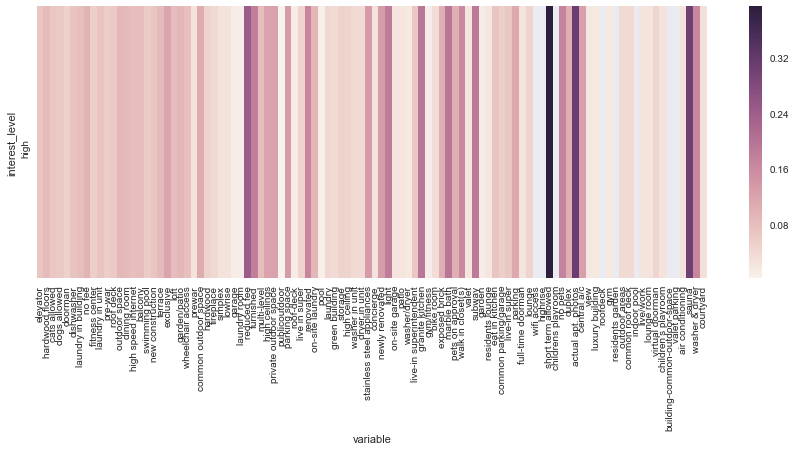

In [301]:
plt.figure(figsize=(15, 5))
sns.heatmap(top_features_proportions.sort_values('total', ascending=False)[['high']].T)

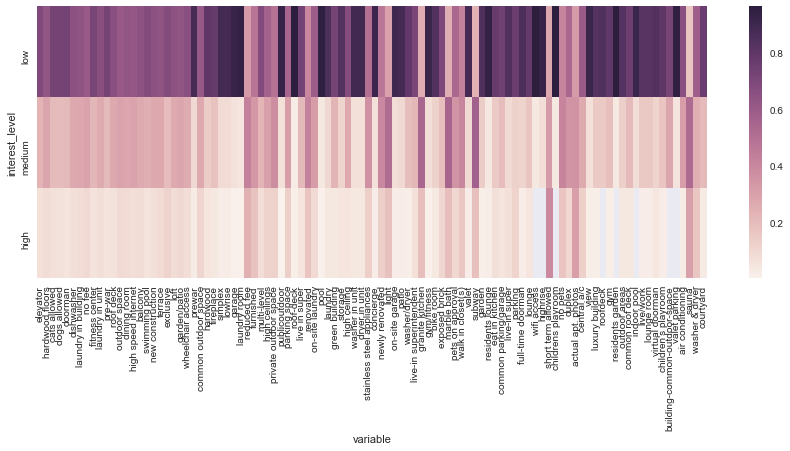

In [303]:
plt.figure(figsize=(15, 5))
sns.heatmap(top_features_proportions.sort_values('total', ascending=False)[['low', 'medium', 'high']].T)

In [314]:
most_common_features = [x for x in most_common_features if x not in ['interest_level','listing_id']]

In [317]:
features_melted.listing_id.nunique()

46045

In [324]:
feature_dummy_matrix_train = pd.pivot_table(features_melted, index='listing_id', columns='variable', values='value').fillna(0).astype(int)

In [507]:
from sklearn.feature_extraction import text

In [530]:
train['features_unlist'] = train["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test['features_unlist'] = test["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))

In [531]:
tfidf = text.CountVectorizer(stop_words='english', max_features=200)

In [552]:
train_ft_tfidf_transformed = tfidf.fit_transform(train["features_unlist"])
test_ft_tfidf_transformed = tfidf.transform(test["features_unlist"])

In [534]:
from scipy import sparse

In [506]:
feature_dummy_matrix_train.shape

(46045, 100)

In [325]:
feature_dummy_matrix_train.head(1)

variable,actual apt. photos,air conditioning,balcony,bike room,building-common-outdoor-space,cats allowed,central a/c,children's playroom,childrens playroom,common outdoor space,...,valet,valet parking,view,virtual doorman,walk in closet(s),washer & dryer,washer in unit,washer/dryer,wheelchair access,wifi access
listing_id,,,,,,,,,,,,,,,,,,,,,
6811957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [346]:
feature_counts_test = list()
for name, i in test.loc[test.n_features > 0].iterrows():
    id_d = {'listing_id': name}
    feature_list = [x.lower() for x in i.features]
    get_punct_out = lambda x: (x
                              .replace(',', '')
                              .replace('  ',' ')
                              .replace('\n', '')
                              .replace('_', '')
                              .replace('.', '')
                              .replace('!', '')
                              .replace('*', '')
                              )
    vals_d = pd.Series(feature_list).value_counts().to_dict()
    row_dict = {**id_d, **vals_d}
    feature_counts_test.append(row_dict)



feature_counts_test = pd.DataFrame(feature_counts)
feature_counts_test = feature_counts_test.set_index('listing_id')

In [347]:
feature_dummy_matrix_test = feature_counts_test[most_common_features].fillna(0).astype(int)

In [137]:
train['length_of_each_feature'] = train.features.apply(lambda x: [len(x) for x in x])


In [307]:
train['has_feature_over_20_char'] = train.length_of_each_feature.apply(lambda x: any([x > 10 for x in x]))

In [310]:
train.groupby(['interest_level', 'has_feature_over_20_char']).size()

interest_level  has_feature_over_20_char
high            False                         663
                True                         3176
low             False                        5067
                True                        29217
medium          False                        1371
                True                         9858
dtype: int64

In [153]:
## what are the high and medium interest features?

In [116]:
## how many have these long description lengths for one feature?

In [348]:
train.shape

(49352, 30)

In [350]:
train = train.merge(feature_dummy_matrix_train, how='left', left_index=True, right_index=True)

In [361]:
train.loc[:,most_common_features] = train.loc[:,most_common_features].fillna(0).astype(int)

In [364]:
test = test.merge(feature_dummy_matrix_test, how='left', left_index=True, right_index=True)

In [365]:
test.loc[:,most_common_features] = test.loc[:,most_common_features].fillna(0).astype(int)

should look for the most desirable features

## photos

In [79]:
train['n_photos'] = train.photos.apply(lambda x: len(x))
test['n_photos'] = test.photos.apply(lambda x: len(x))

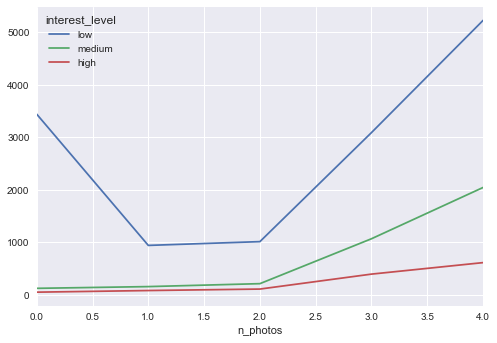

In [80]:
(train
.loc[train.n_photos < 5]
.groupby(['n_photos', 'interest_level'])
.size().reset_index()
.pipe(pd.pivot_table, columns='interest_level', index='n_photos', values=0)
.fillna(0).astype(int)
 [['low', 'medium', 'high']]
.plot.line()
)

looks like a the zero photos 

In [81]:
train.loc[:,'has_zero_photos'] = 0
train.loc[train.n_photos == 0, 'has_zero_photos'] = 1
train.groupby(['interest_level', 'has_zero_photos']).size()

interest_level  has_zero_photos
high            0                   3789
                1                     50
low             0                  30842
                1                   3442
medium          0                  11106
                1                    123
dtype: int64

In [82]:
test.loc[:,'has_zero_photos'] = 0
test.loc[test.n_photos == 0, 'has_zero_photos'] = 1

## display address

In [83]:
display_x_tab = (train
 .groupby(['display_address', 'interest_level'])
 .size().reset_index()
 .pipe(pd.pivot_table, columns='interest_level', index='display_address', values=0)
 .fillna(0).astype(int)
 [['low', 'medium', 'high']]
)

In [84]:
display_x_tab_proportions = display_x_tab.divide(display_x_tab.sum(1), 0)

In [85]:
low_interest_addresses = display_x_tab_proportions.loc[((display_x_tab.sum(1) > 20) & (display_x_tab_proportions.low > 0.9))]
low_interest_addresses.index.values

array(['5th Ave.', '888 Eighth Avenue', 'Broad Street', 'Center Boulevard',
       'Central Park West', 'Charles Street', 'Cliff Street',
       'Cooper Square', 'E 14 Street', 'E 28th St', 'E 49th St.',
       'E 63rd St.', 'E 72 Street', 'E 72nd St.', 'E 77 Street',
       'E 84th St.', 'E 86 Street', 'E 87th St.', 'E 89th St.',
       'East 100th Street', 'East 117th Street', 'East 1st Street',
       'East 20th Street', 'East 49th Street', 'East 60th Street',
       'East 65th Street', 'East 66th Street', 'East 72nd Street',
       'East 77th Street', 'East 92nd Street', 'East 96th Street',
       'Greenwich Avenue', 'Horatio Street', 'Jones Street',
       'Lawrence Street', 'Manhattan Avenue', 'North 10th Street',
       'Peter Cooper Road', 'Riverside Blvd', 'Riverside Boulevard',
       'Saint Nicholas Avenue', 'Spruce Street', 'St Marks Place',
       'Stuyvesant Oval', 'Union Square South', 'W 55 Street',
       'W 57 Street', 'W 58 Street', 'W 62 St.', 'W 63rd St.',
       '

In [86]:
train.loc[train.display_address.isin(low_interest_addresses.index.values)].groupby(['interest_level']).size()

interest_level
high        21
low       2777
medium     179
dtype: int64

In [87]:
train.loc[:, 'low_interest_display_address'] = 0
train.loc[train.display_address.isin(low_interest_addresses.index.values), 'low_interest_display_address'] = 1

In [88]:
test.loc[:, 'low_interest_display_address'] = 0
test.loc[test.display_address.isin(low_interest_addresses.index.values), 'low_interest_display_address'] = 1

In [89]:
## don't seem to be many that are high interest?

display_x_tab_proportions.loc[((display_x_tab.sum(1) > 5) & (display_x_tab_proportions.high > 0.9))]

interest_level,low,medium,high
display_address,,,
Carlton St,0.0,0.0,1.0


In [90]:
train.loc[train.display_address == 'Carlton St'].interest_level.value_counts()

high    6
Name: interest_level, dtype: int64

## transformations?

In [91]:
from scipy.special import logit

In [92]:
train['log_price'] = np.log(train.price)
test['log_price'] = np.log(test.price)

In [93]:
train['log_description_length'] = np.log(train.description_length + 0.01)
train['log_description_length'] = train['log_description_length'].fillna(0)

test['log_description_length'] = np.log(test.description_length + 0.01)
test['log_description_length'] = test['log_description_length'].fillna(0)



In [ ]:


# target_num_map = {'high':0, 'medium':1, 'low':2}
# train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
# print(train_X.shape, test_X.shape)

# some basic predictions

In [367]:
from sklearn import model_selection, linear_model, metrics, preprocessing

setup test and train

In [481]:
!ls

Explore.ipynb               low_importance_list
data                        test_submission.csv
low_importance_features.csv


In [486]:
## to include features based from unpacking of feature list extend below with
## most_common_features

model_features = ['bathrooms', 
            'bedrooms', 
            'description_length', 
            'latitude', 
            'longitude', 
            'low_interest_manager_id',
           'low_interest_building_id', 
            'no_building_id',
           'n_features', 
            'n_photos', 
            'has_zero_photos',
           'low_interest_display_address',
           'hour_of_day', 
            'price']
model_features.extend(most_common_features)
## created using random forecast variable importance
low_importance_features = pd.read_csv('low_importance_features.csv').feature.tolist()
model_features = [x for x in model_features if x not in low_importance_features]

In [577]:
#X = train[model_features]
y = train['interest_level'].values

sss = model_selection.StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=0)
sss.get_n_splits(X=X, y=y)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [17984 36593  7219 ..., 17629 40833 20954] TEST: [37887 39631 10074 ..., 20903 26267 16106]
TRAIN: [47718 17388 47139 ..., 12099 27110 39561] TEST: [  501 33857  9196 ...,  7458 31635 42554]


fit model

In [578]:
# default model to fit is one vs rest 
# tried multinomial and it was worse...
logreg = linear_model.LogisticRegression()

In [579]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

evaluate

In [580]:
y_pred = logreg.predict_proba(X_test)

In [581]:
y_pred_labels = logreg.predict(X_test)

In [582]:
metrics.log_loss(y_true=y_test, y_pred=y_pred)

0.6416194750351133